In [34]:
## Powered by: 
## Illia Tsuprun
## Illia Savenko

In [1]:
import numpy as np
import pandas as pd
import datetime
import pandas_datareader.data as web
from pandas import Series, DataFrame, read_csv

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib as mplt

import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
from sklearn.metrics import r2_score
import ml_metrics as metrics

# 1. Візуальне відображення у вигляді графіків
На основі такого попереднього аналізу є можливість оцінити ряд
на наявність сезонних ефектів, викидів, пропусків, тощо і використати
дану інформацію для подальшого моделювання.

In [2]:
start = datetime.datetime(2005, 1, 1)
end = datetime.datetime(2021, 1, 11)

df = web.DataReader("AAPL", "yahoo", start, end)

closing_metric = df["Close"]
series = df["Close"].to_numpy()
print("Shape of the series: ", len(series))
time = np.arange(0.0, len(series))

df.head()

Shape of the series:  4034


High       Low      Open     Close        Volume  Adj Close
Date                                                                       
2005-01-03  1.162679  1.117857  1.156786  1.130179  6.919920e+08   0.966324
2005-01-04  1.169107  1.124464  1.139107  1.141786  1.096810e+09   0.976247
2005-01-05  1.165179  1.143750  1.151071  1.151786  6.804336e+08   0.984797
2005-01-06  1.159107  1.130893  1.154821  1.152679  7.055552e+08   0.985561
2005-01-07  1.243393  1.156250  1.160714  1.236607  2.227450e+09   1.057321

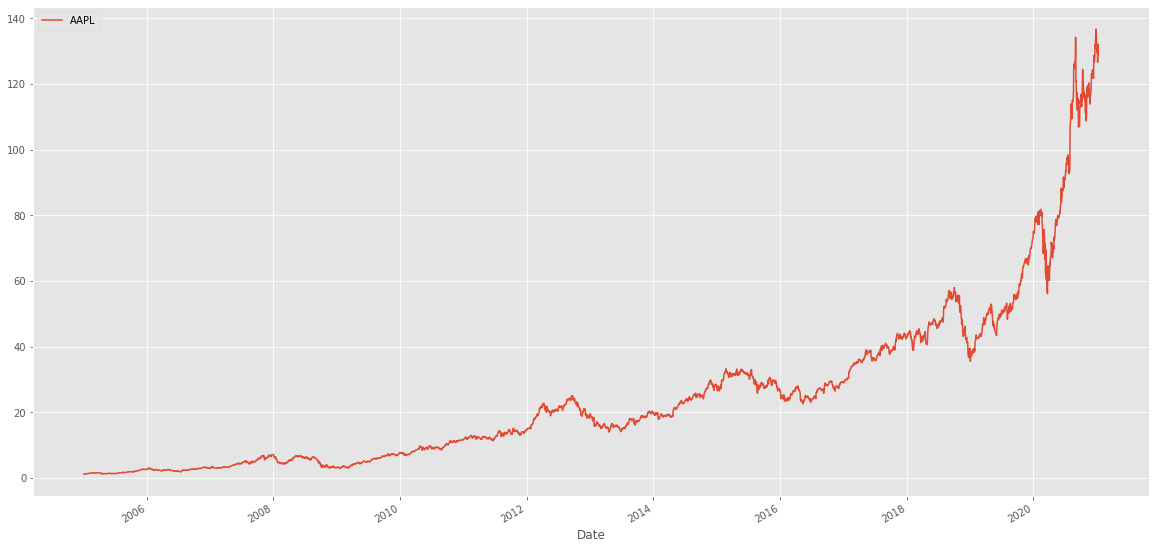

In [3]:
mplt.rc("figure", figsize=(20, 10))
mplt.__version__

style.use("ggplot")
closing_metric.plot(label="AAPL")
plt.legend()
# plt.scatter(x, y_exp)

## Зайшовши до вікіпедії та прогугливши усі моделі можна побачити що стоки йдуть вгору разом з випуском компанією моделей

<AxesSubplot:xlabel='Date'>

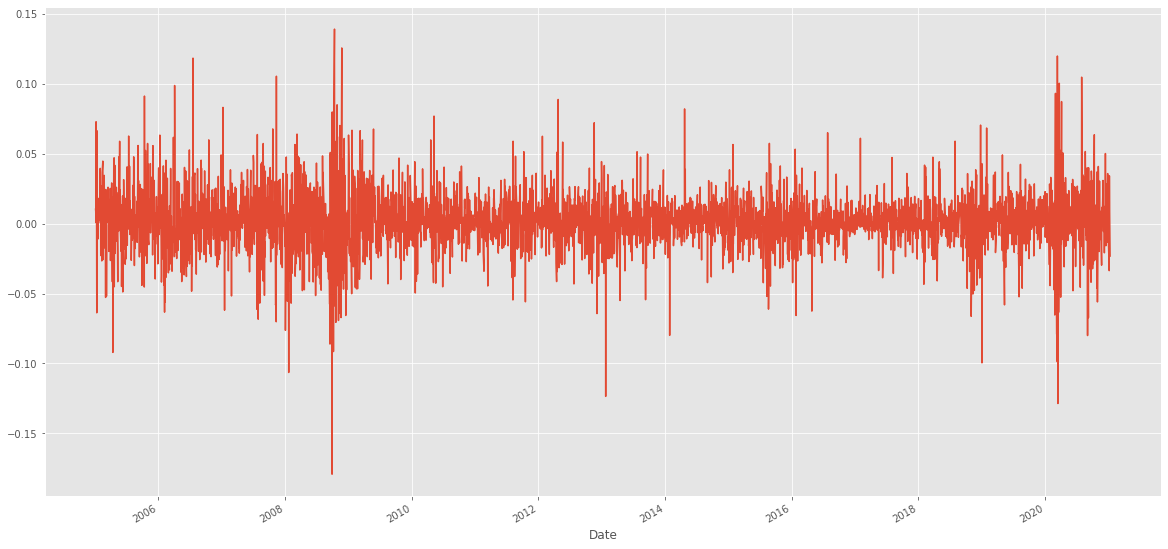

In [4]:
returns = closing_metric / closing_metric.shift(1) - 1
returns.plot(label="return")

### Перевірка на наявніть з цих перелічених характеристик для заданого часового ряду (Попередній аналіз)
- Тренд (Trend)
- Seasonality (Сезонність)
- Автокореляція (Autocorrelation) 
- Шум (Noise)

1. Тренд - бачимо збільшення вартості стоку експоненційно.
2. Про сезонність у часі складно описувати, оскільки часовий ряд не має явно виражених сезонних рухів.
3. Автокореляція - виявити на етапі розгляду людиною склдано
4. Шум невеликий

# 2. Визначення часових періодів для побудови моделі
## Поділ набору даних (використовуватимемо fixed partitioning)

In [5]:
close_series = df['Close']
close_series.head()

Date
2005-01-03    1.130179
2005-01-04    1.141786
2005-01-05    1.151786
2005-01-06    1.152679
2005-01-07    1.236607
Name: Close, dtype: float64

## Data visualization

<AxesSubplot:xlabel='Date'>

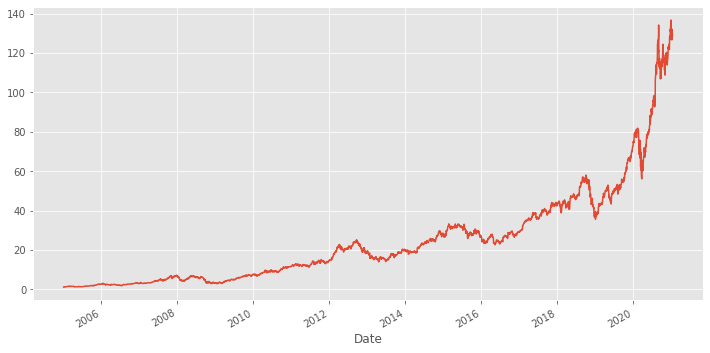

In [6]:
close_series.plot(figsize = (12,6))

In [7]:
description = close_series.describe()
description

count    4034.000000
mean       24.570628
std        24.990428
min         1.130179
25%         5.858839
50%        18.556429
75%        32.471876
max       136.690002
Name: Close, dtype: float64

<AxesSubplot:>

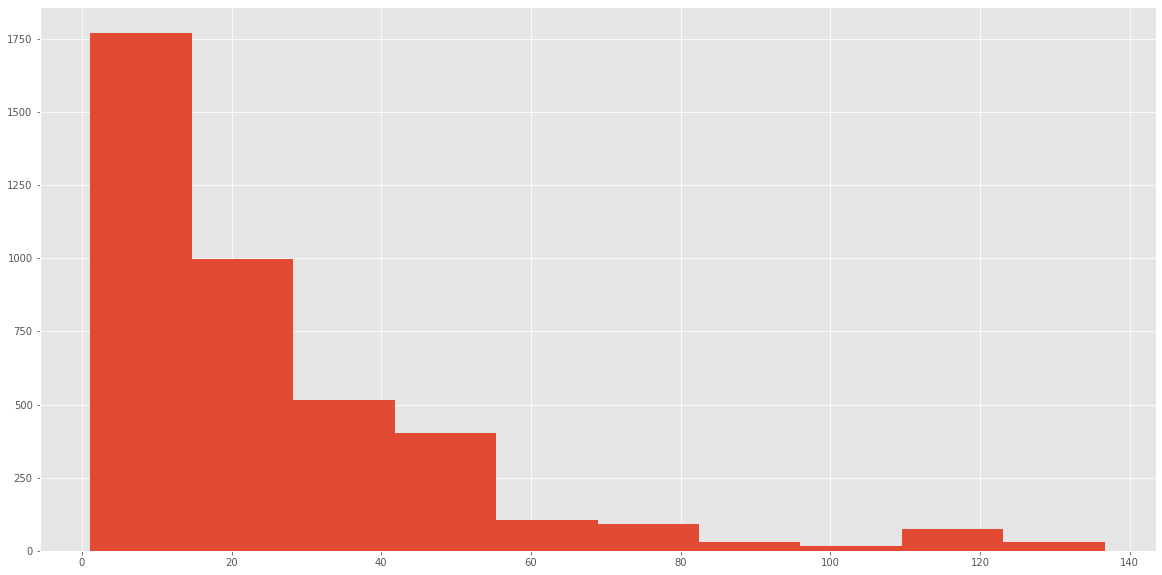

In [8]:
close_series.hist()

## Data preprocessing

In [9]:
close_series

Date
2005-01-03      1.130179
2005-01-04      1.141786
2005-01-05      1.151786
2005-01-06      1.152679
2005-01-07      1.236607
                 ...    
2021-01-05    131.009995
2021-01-06    126.599998
2021-01-07    130.919998
2021-01-08    132.050003
2021-01-11    128.979996
Name: Close, Length: 4034, dtype: float64

## Учитывая наличие пропусков, а также большое количество скачков, сделаем среднюю аггрегацию данных по месяцам

<AxesSubplot:xlabel='Date'>

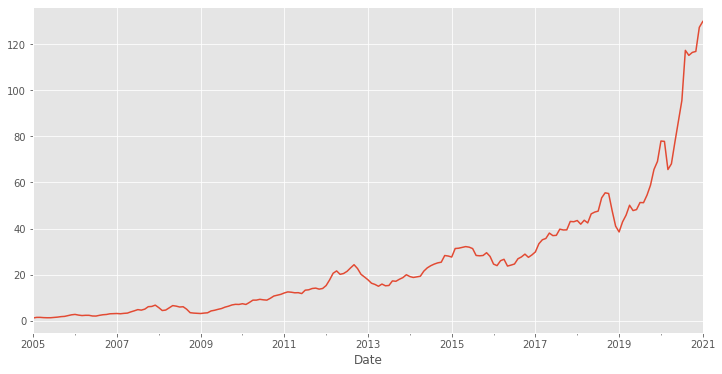

In [10]:
close_series = close_series.resample('M').mean()
close_series.plot(figsize=(12,6))

In [11]:
close_series

Date
2005-01-31      1.236223
2005-02-28      1.495216
2005-03-31      1.499919
2005-04-30      1.383248
2005-05-31      1.332925
                 ...    
2020-09-30    115.125237
2020-10-31    116.413182
2020-11-30    116.825999
2020-12-31    127.290455
2021-01-31    129.828332
Freq: M, Name: Close, Length: 193, dtype: float64

### Variation coefficient

In [12]:
# Variation coefficient
print('V = %f' % (description['std']/description['mean']))

V = 1.017085


### Jargue Bera test

In [13]:
row =  [u'JB', u'p-value', u'skew', u'kurtosis']
jb_test = sm.stats.stattools.jarque_bera(close_series)
a = np.vstack([jb_test])
itog = SimpleTable(a, row)
print(itog)

        JB               p-value                skew             kurtosis    
-----------------------------------------------------------------------------
270.1697621887472 2.1546739057650123e-59 1.9414029463840954 7.303493726816929
-----------------------------------------------------------------------------


### Подтверждается гипотеза про неоднородность ряда

### Тест Дики-Фуллера на стационарность ряда

In [14]:
test = sm.tsa.adfuller(close_series)
print('adf: ', test[0]) 
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  2.1482454862954206
p-value:  0.9988371486250311
Critical values:  {'1%': -3.467845319799907, '5%': -2.878011745497439, '10%': -2.575551186759871}
есть единичные корни, ряд не стационарен


- Проведенный тест подтвердил предположения о не стационарности ряда. 
- Во многих случаях взятие разности рядов позволяет это сделать.
- Если, например, первые разности ряда стационарны, то он называется интегрированным рядом первого порядка.
- Итак, давайте определим порядок интегрированного ряда для нашего ряда:

In [15]:
close1diff = close_series.diff(periods=1).dropna()

In [16]:
test = sm.tsa.adfuller(close1diff)
print('adf: ', test[0]) 
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  2.213854272566346
p-value:  0.9988937122140665
Critical values:  {'1%': -3.4680615871598537, '5%': -2.8781061899535128, '10%': -2.5756015922004134}
есть единичные корни, ряд не стационарен


In [17]:
close2diff = close1diff.diff(periods=1).dropna()

In [18]:
test = sm.tsa.adfuller(close2diff)
print('adf: ', test[0]) 
print('p-value: ', test[1])
print('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print('есть единичные корни, ряд не стационарен')
else:
    print('единичных корней нет, ряд стационарен')

adf:  -4.923300284500814
p-value:  3.140963453411175e-05
Critical values:  {'1%': -3.4680615871598537, '5%': -2.8781061899535128, '10%': -2.5756015922004134}
единичных корней нет, ряд стационарен


- Как видно из кода выше получившийся ряд вторых разностей приблизился к стационарному
- Для полной уверенности разобъем его на несколько промежутков и убедимся мат. ожидания на разных интервалах:

In [19]:
m = close2diff.index[int(len(close2diff.index)/2)]
r1 = sm.stats.DescrStatsW(close2diff[m:])
r2 = sm.stats.DescrStatsW(close2diff[:m])
print('p-value: ', sm.stats.CompareMeans(r1,r2).ttest_ind()[1])

p-value:  0.9038584073888563


<AxesSubplot:xlabel='Date'>

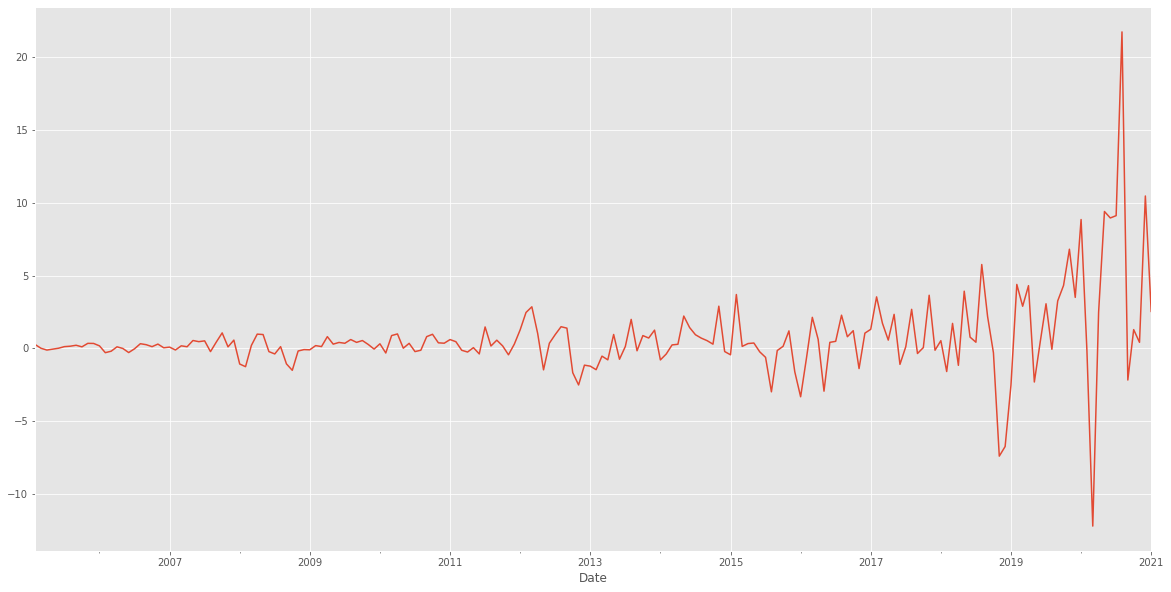

In [20]:
close1diff.plot()

#### ВЫсокое p-value + отсутствие тренда = стационарный ряд, исходный ряд - интегрированный ряд второго порядка

# ARIMA - auto regression with moving average

## Построение модели временного ряда

Для моделирования будем использовать модель ARIMA, построенную для ряда первых разностей.
Итак, чтобы построить модель нам нужно знать ее порядок, состоящий из 2-х параметров:

    p — порядок компоненты AR
    d — порядок интегрированного ряда
    q — порядок компонетны MA



- Параметр d есть и он равет 2, осталось определить p и q. 
- Для их определения нам надо изучить авторкорреляционную(ACF) и частично автокорреляционную(PACF) функции для ряда первых разностей.
- ACF поможет нам определить q, т. к. по ее коррелограмме можно определить количество автокорреляционных коэффициентов сильно отличных от 0 в модели MA
- PACF поможет нам определить p, т. к. по ее коррелограмме можно определить максимальный номер коэффициента сильно отличный от 0 в модели AR.
- Чтобы построить соответствующие коррелограммы, в пакете statsmodels имеются следующие функции: plot_acf() и plot_pacf(). Они выводят графики ACF и PACF, у которых по оси X откладываются номера лагов, а по оси Y значения соответствующих функций. Нужно отметить, что количество лагов в функциях и определяет число значимых коэффициентов. Итак, наши функции выглядят так:

/home/itsuprun/.local/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


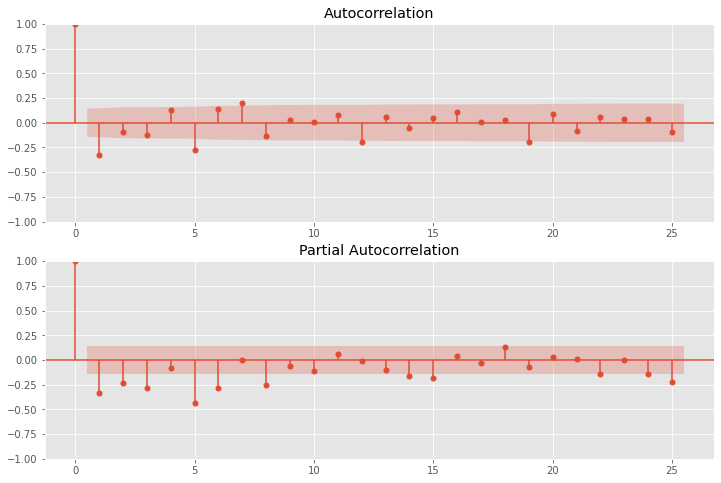

In [21]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(close2diff.values.squeeze(), lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(close2diff, lags=25, ax=ax2)

### После изучения коррелограммы PACF можно сделать вывод, что p = 1, т.к. на ней только 1 лаг сильно отличнен от нуля. 
### По коррелограмме ACF можно увидеть, что q = 1, т.к. после лага 1 значении функций резко падают.
### Итак, когда известны все параметры можно построить модель, но для ее построения мы возмем не все данные, а только часть. 
### Данные из части не попавших в модель мы оставим для проверки точности прогноза нашей модели:

<AxesSubplot:xlabel='Date'>

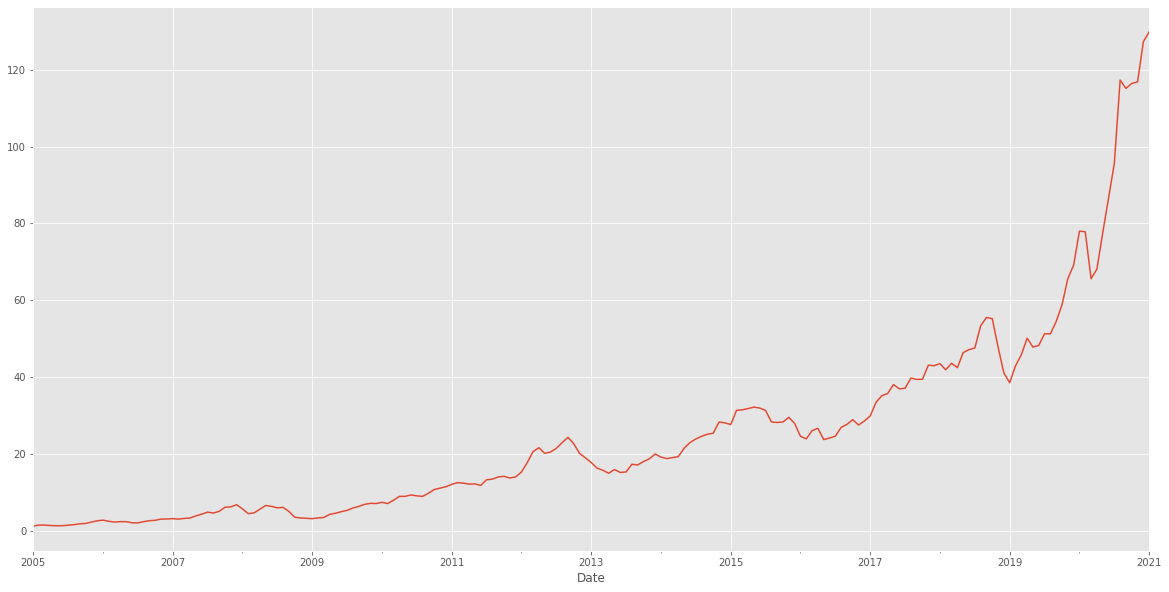

In [22]:
close_series.plot()

In [23]:
close_series

Date
2005-01-31      1.236223
2005-02-28      1.495216
2005-03-31      1.499919
2005-04-30      1.383248
2005-05-31      1.332925
                 ...    
2020-09-30    115.125237
2020-10-31    116.413182
2020-11-30    116.825999
2020-12-31    127.290455
2021-01-31    129.828332
Freq: M, Name: Close, Length: 193, dtype: float64

In [24]:
train = close_series[:'2018-09-30':]
test = close_series['2018-09-30':]

In [25]:
print("Train length", train.shape[0])
print("Test length", test.shape[0])

Train length 165
Test length 29


In [26]:
model = sm.tsa.ARIMA(train, order=(1,2,1), freq='M').fit()

In [27]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  165
Model:                 ARIMA(1, 2, 1)   Log Likelihood                -260.666
Date:                Mon, 20 Jun 2022   AIC                            527.333
Time:                        21:14:59   BIC                            536.614
Sample:                    01-31-2005   HQIC                           531.101
                         - 09-30-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1549      0.079      1.956      0.050      -0.000       0.310
ma.L1         -0.9603      0.030    -31.968      0.000      -1.019      -0.901
sigma2         1.4143      0.107     13.238      0.0

### Как видно из данной информации в нашей модели все коэффициенты значимые и можно перейти к оценке модели.

## Анализ и оценка модели

#### Проверим остатки данной модели на соответствие «белому шуму», а также проанализируем коррелограму остатков, так как это может нам помочь в определении важных для включения и прогнозирования элементов регрессии.

#### Итак первое, что мы сделаем это проведем Q-тест Льюнга — Бокса для проверки гипотезы о том, что остатки случайны, т. е. являются «белым шумом». Данный тест проводится на остатках модели ARIMA. Таким образом, нам надо сначала получить остатки модели и построить для них ACF, а затем к получившимся коэффициентам приметить тест. С помощью statsmadels это можно сделать так:

In [28]:
q_test = sm.tsa.stattools.acf(model.resid, qstat=True) #свойство resid, хранит остатки модели, qstat=True, означает что применяем указынный тест к коэф-ам
print(DataFrame({'Q-stat':q_test[1], 'p-value':q_test[2]}))

       Q-stat   p-value
0    0.017848  0.893721
1    0.255690  0.879990
2    0.504929  0.917807
3    0.511833  0.972339
4    2.261505  0.811904
5    3.278746  0.773135
6    3.325918  0.853305
7    5.953064  0.652490
8    6.779571  0.660057
9    7.560963  0.671635
10   8.841017  0.636564
11   9.657435  0.645985
12   9.809396  0.709442
13  13.106786  0.518133
14  13.108598  0.593910
15  13.113466  0.664444
16  13.470138  0.704189
17  14.233448  0.713751
18  15.088677  0.716945
19  15.135969  0.768575
20  15.160211  0.814828
21  15.192329  0.853853


### Значение данной статистики и p-values, свидетельствуют о том, что гипотеза о случайности остатков не отвергается, и скорее всего данный процесс представляет «белый шум».
### Теперь давайте расчитаем коэффициент детерминации, чтобы понять какой процент наблюдений описывает данная модель:

In [29]:
pred = model.predict('2018-09-30','2021-01-17', typ='levels')

## R^2

In [30]:
r2 = r2_score(test, pred)
print('R^2: %1.2f' % r2)

R^2: 0.37


## Среднеквадратичное отклонение нашей модели:

In [31]:
metrics.rmse(test,pred)

22.26200022655696

## Средняя абсолютная ошибка прогноза:

In [32]:
metrics.mae(test,pred)

16.99473255037561

## Визуализация прогноза

<AxesSubplot:xlabel='Date'>

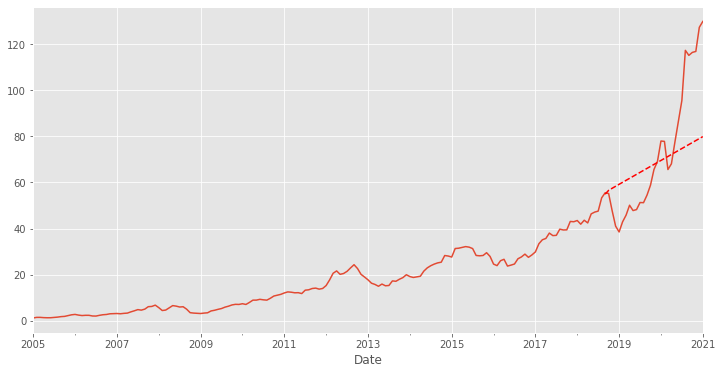

In [33]:
close_series.plot(figsize=(12,6))
pred.plot(style='r--')

## Заключение

- Как можно заметить из графика наша модель строит не очень хороший прогноз. 
- Отчасти это связано с выбросами в исходных данных, которые мы не доконца убрали, а также с модулем ARIMA пакета statsmodels, т. к. он достаточно новый.